# Housing Prices - Advanced Regression Techniques

### James Mwakichako - jmwakich@hawk.iit.edu
### Michael Baroody  - mbaroody@hawk.iit.edu

## Description

The purpose of this project is to predict the final sale price of a home, given features of a house such as square footage, number of pools, garage condition, etc. Initially, we are given 80 features and 1460 datapoints. Of course, not all of this data is clean. There are several problems with our dataset:

* missing values
* NaN values
* categorical data that needs to be encoded.

This document outlines some of the approaches that we took to deal with these issues as well as the models we used to fit our processed data.

Below is a widget that you might find helpful when navigating through our data. 

Mean: 1084.92
Variance: 167501.79
Percent values missing: 0.000000%


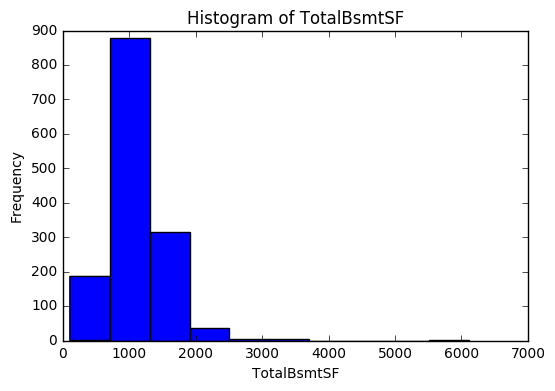

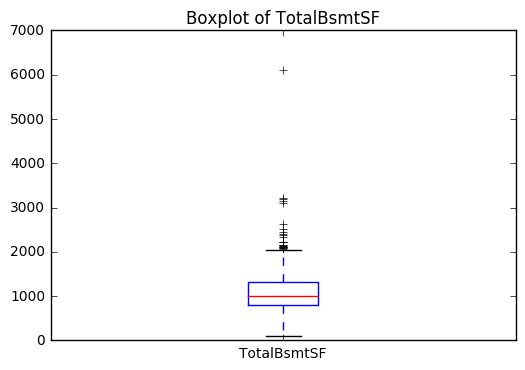

<function __main__.display_stats>

In [9]:
%matplotlib inline
import pandas as pd
from ipywidgets import widgets
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing, linear_model, model_selection, neural_network, ensemble, tree

# train DataFrame object
# see http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html
# and http://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html
train = pd.read_csv("train.csv", header = 0)

features = [feature for feature in train.columns.values]

features_dropdown = widgets.Dropdown(
    options=sorted(features),
    value='TotalBsmtSF',
    description='Feature',
    disabled=False,
    button_style='info'
)

categorical_features = [cat_feature for cat_feature in train.columns.values if train[cat_feature].dtype == 'object']
categorical_features.extend(['MSSubClass', 'OverallQual', 'OverallCond', 'BsmtFullBath', 
                             'BsmtHalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 
                             'TotRmsAbvGr', 'Fireplaces', 'GarageCars', 'MoSold', 'YrSold'])


def display_stats(feature):
    
    if feature in categorical_features:
        stringified = train[feature].apply(lambda x: str(x)).values
        print("Percent values missing: %f%%" % (100*(np.sum(stringified == 'nan') / len(train[feature].values))))
        
        nan_indices = np.where(stringified == 'nan')[0]
        stringified = np.delete(stringified, nan_indices)
        
        labels = np.unique(stringified)
        data = [np.sum(stringified == l) for l in labels]
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        ax.set_title('Visualization of %s' % feature)
        ax.set_xlabel(feature)
        ax.set_ylabel('Frequency')
        if feature == 'MoSold':
            labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        ax.bar(range(len(data)), data, tick_label=labels)
        #ax.xticks(range(len(lables)), labels)
        plt.show()
    else:
        x = train[feature].values
    
        #find zero indices
        zero_indices = np.where(x == 0)[0]
        nan_indices = np.where(np.isnan(x))[0]
        #delete these datapoints from x and y
    
        x = np.delete(x, zero_indices)
        x = np.delete(x, nan_indices)
        
        print('Mean: %.2f' % np.mean(x))
        print('Variance: %.2f' % np.var(x))
        # we don't count zeros as missing
        print('Percent values missing: %f%%' % (100*((len(nan_indices)) / len(train[feature].values))))
    
        fig1 = plt.figure(1)
        ax1 = fig1.add_subplot(1, 1, 1)
        ax1.set_title('Histogram of %s' % feature)
        ax1.set_xlabel(feature)
        ax1.set_ylabel('Frequency')
        ax1.hist(x)
        
        fig2 = plt.figure(2)
        ax2= fig2.add_subplot(1, 1, 1)
        ax2.set_title('Boxplot of %s' % feature)
        ax2.boxplot([list(x)], labels=[feature])
        plt.show()

widgets.interact(display_stats, feature=features_dropdown)

In [10]:
print(train.shape)

(1460, 81)


## Preprocessing

### Preprocessing Step 1 - Missing Values

Recall that we had some features with many missing values (refer to widget above). We want to throw out all features that have > 25% missing values. That means 'PoolQC', 'MiscFeature', 'Alley', 'Fence', and 'FireplaceQu' will all be excluded from the training data. We also don't care about the 'Id' for obvious reasons, and 'Utilities' because virtually all datapoints have the same value for the 'Utilities' feature (again, refer to widget). 

In [11]:
del train['PoolQC']
del train['MiscFeature']
del train['Alley']
del train['Fence']
del train['FireplaceQu']
del train['Id']
del train['Utilities']

print(train.shape)

(1460, 74)


### Preprocessing Step 2 - Sorting Feature Types

We decided to separate our data into three types: ordered categorical data (scales of 1-10, condition ratings, etc), unordered categorical data, and continuous data. Note that we included some features in the continuous set that could be considered categorical (like the 'YearSo'). Our reasons for separating the data as we did should be obvious when you inspect their distribution with the widget. Below are the features and their respective types: 

In [12]:
# purposefully-ordered 
ordered_categorical_features = ['OverallCond', 'Fireplaces', 'GarageCars', 
                                'TotRmsAbvGrd', 'BedroomAbvGr', 'FullBath', 
                                'BsmtFullBath', 'OverallQual', 'KitchenQual', 
                                'CentralAir', 'HeatingQC', 'BsmtCond', 'BsmtQual', 
                                'ExterCond', 'ExterQual', 'BsmtHalfBath', 'GarageCond',
                                'GarageQual']

# arbitrarily-ordered
unordered_categorical_features = ['MSZoning', 'Street', 'LotShape', 
                                  'LandContour', 'LotConfig', 'LandSlope', 
                                  'Neighborhood', 'Condition1', 'Condition2', 
                                  'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 
                                  'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 
                                  'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 
                                  'Electrical', 'GarageFinish', 'Functional', 'GarageType', 
                                  'PavedDrive', 'SaleType', 'SaleCondition', 
                                  'MSSubClass', 'PoolArea', 'MoSold']

# note choice of years as continuous 
continuous_features = ['LotFrontage', 'LotArea', 'YearBuilt', 
                       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 
                       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 
                       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 
                       'GrLivArea', 'HalfBath', 'KitchenAbvGr',
                       'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 
                       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 
                       'ScreenPorch', 'MiscVal', 'YrSold']
    

### Preprocessing Step 3 - Imputing Values

In this step, we must fill in the missing ('NaN') values. For the continuous features, we will want to fill in the missing values with the mean for that column. For example, we know that the mean value for all of the known 'LotFrontage' values is around 70. Therefore, for all of the 'NaN' values encountered in the 'LotFrontage' column, we will replace the value with 70.

In [13]:
means = {feat:np.nanmean(train[feat].values) for feat in continuous_features}
for feature,mean in means.items():
    train[feature] = train[feature].fillna(value=mean)

For the categorical features (unordered and ordered), we will fill in the missing values with the mode category for that column. For example, it is known that the most frequent 'GarageQual' is 'TA.' Therefore, for all of the 'NaN' values we encounter in the 'GarageQual' column, we will replace the value with 'TA.'

In [14]:
# fill in the missing categorical values with the modes 
categorical_features = unordered_categorical_features + ordered_categorical_features
modes = {feat:train[feat].mode()[0] for feat in categorical_features}
for feature,mode in modes.items():
    train[feature] = train[feature].fillna(value=mode)

### Preprocessing Step 3 - Encoding Categorical Values

Now we must encode the categorical features. The unordered categorical features need to be transformed using a similar approach to OneHotEncoder (but using pandas.get_dummies). Some ordered categorical features need special treatement (i.e. they are of dtype='object'). However, many of the ordered categorical variables are already encoded. For example, 'OverallCond' (see widget). 

In [15]:
# similar to OneHotEncoder, this section of code will pass through all 
# unordered categorical features, expanding the training data by 
# numCols columns, where numCols = len(train[feat].columns)
# each coll
for feat in unordered_categorical_features:
    dummies = pd.get_dummies(train[feat], prefix=feat)
    train[dummies.columns] = dummies
    train = train.drop(feat, 1)

# simple encoding scheme much like http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html#sklearn.preprocessing.LabelEncoder
# however, we enforce order with custom encoder
special_encode = ['KitchenQual','HeatingQC','BsmtCond', 
                 'ExterCond', 'ExterQual', 'CentralAir']

CondKey = {
        # Poor 
        'Po' : 1,
        # Fair
        'Fa' : 2,
        # Typical/Average
        'TA' : 3,
        # Good
        'Gd' : 4,
        # Excellent
        'Ex' : 5
}

BinKey = {
    # No
    'N' : 0,
    # Yes
    'Y' : 1
}

def encode(data, key):
    return np.array([key[d] for d in data])

train['KitchenQual'] = encode(train['KitchenQual'], CondKey)
train['HeatingQC'] = encode(train['HeatingQC'], CondKey)
train['BsmtCond'] = encode(train['BsmtCond'], CondKey)
train['BsmtQual'] = encode(train['BsmtQual'], CondKey)
train['ExterCond'] = encode(train['ExterCond'], CondKey)
train['ExterQual'] = encode(train['ExterQual'], CondKey)
train['GarageCond'] = encode(train['GarageCond'], CondKey)
train['GarageQual'] = encode(train['GarageQual'], CondKey)
train['CentralAir'] = encode(train['CentralAir'], BinKey)



## Model Selection (Performance Measure R-Squared)

In [16]:
# and http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop.html#pandas.DataFrame.drop
X = train.drop('SalePrice', 1)
y = train['SalePrice']

# see http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn-linear-model-lasso
lasso = linear_model.Lasso(alpha=10.0)
lasso_avg = np.mean(model_selection.cross_val_score(lasso, X, y, cv=10, scoring='r2'))

# http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression
linReg = linear_model.LinearRegression()
linReg_avg = np.mean(model_selection.cross_val_score(lasso, X, y, cv=10, scoring='r2'))

# http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
forest = ensemble.RandomForestRegressor()
forest_avg = np.mean(model_selection.cross_val_score(forest, X, y, cv=10, scoring='r2'))

# http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html
ada = ensemble.AdaBoostRegressor()
ada_avg = np.mean(model_selection.cross_val_score(ada, X, y, cv=10, scoring='r2'))

# 
gradient = ensemble.GradientBoostingRegressor()
gradient_avg = np.mean(model_selection.cross_val_score(gradient, X, y, cv=10, scoring='r2'))

# http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html
decision = tree.DecisionTreeRegressor()
decision_avg = np.mean(model_selection.cross_val_score(decision, X, y, cv=10, scoring='r2'))


print('Classifier\t\t\tCross Val Score Average (folds=10)')
print('----------\t\t\t-------------------------------------------')
print('Lasso\t\t\t\t%0.3f' % lasso_avg)
print('Linear\t\t\t\t%0.3f' % linReg_avg)
print('Random Forest\t\t\t%0.3f' % forest_avg)
print('Ada Boost\t\t\t%0.3f' % ada_avg)
print('Decision Tree\t\t\t%0.3f' % decision_avg)
print('Gradient Boosting\t\t%0.3f' % gradient_avg)

/opt/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Classifier			Cross Val Score Average (folds=10)
----------			-------------------------------------------
Lasso				0.826
Linear				0.826
Random Forest			0.843
Ada Boost			0.805
Decision Tree			0.742
Gradient Boosting		0.892


We settled on the Gradient Boosting Regressor for our model, as it consistently resulted in the highest cross-validation score (using 10 folds and 'r2' scoring). 

### In-Depth Look at Model

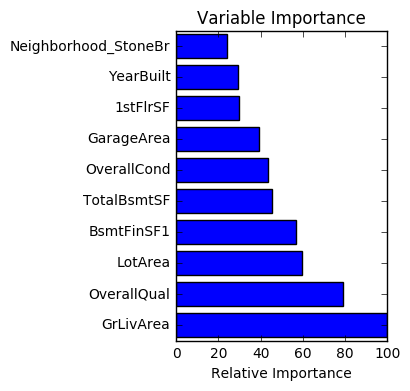

In [17]:
gradient.fit(X, y)
feature_importance = gradient.feature_importances_
#print(feature_importance)
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
#print(len(feature_importance))
#print(feature_importance)
sorted_idx = np.argsort(feature_importance)[::-1][:10]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

As expected, 'GrLivArea' (total ground living area) and 'OverallQual' (rating given to a house) is a very important measure. An interesting feature that made it was the 'Neighborhood' feature. This feature depicts the "physical location within Ames city limits." If a value was "StoneBR," or Stone Brook (remember we OneHotEncoded this feature), then that is an important indicator for the final sale price. 

In [18]:
sorted_idx = np.argsort(feature_importance)[:10]
print('Least Important Features')
print('------------------------')
for feat in X.columns[sorted_idx]:
    print(feat)


Least Important Features
------------------------
Exterior1st_AsphShn
Exterior2nd_CBlock
Exterior2nd_HdBoard
Exterior2nd_Other
Exterior2nd_Plywood
Exterior2nd_Stone
Exterior2nd_VinylSd
Exterior2nd_Wd Sdng
Exterior2nd_Wd Shng
MasVnrType_BrkCmn


Perhaps in the future, we can throw out all of the 'Exterior' features.